# BERT Word Embeddings

## Load Pre-Trained BERT

In [4]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
import matplotlib.pyplot as plt

In [5]:
# Load pre-trained BERT model and tokenizer
model_name = "dbmdz/bert-base-german-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at dbmdz/bert-base-german-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# Read the CSV file
df = pd.read_csv('../data/preprocessed/preprocessed_data.csv')

# Convert the data into strings (requirement of BERT)
df['Content'] = df['Content'].astype(str)

df.head()

,Content
0,ariv favorit brandsget appour visionpartnershi...
1,r ckabwickl lebensversicher hol doppelt leb re...
2,stark versicher f r lifestyl held de hom produ...
3,restub airbag freedom safety wat restub skip c...
4,curevac revolutioni mrna f r leb mensch ber be...


Token indices sequence length is longer than the specified maximum sequence length for this model (1126 > 512). Running this sequence through the model will result in indexing errors


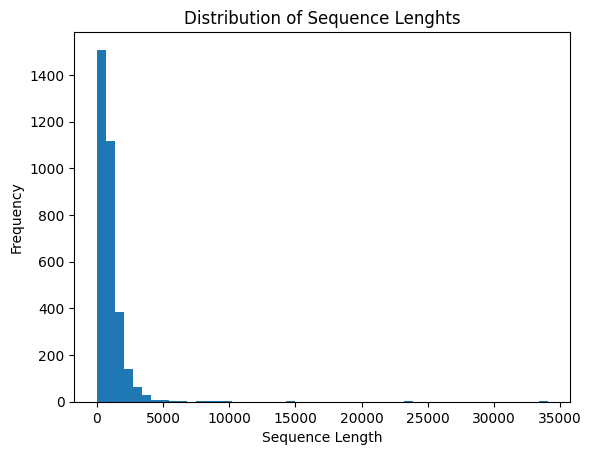

In [7]:
# Function to calculate the sequence lenghts
def calculate_sequence_lengths(text):
    tokens = tokenizer.tokenize(text)
    return len(tokens)

# Apply function
df['sequence_length'] = df['Content'].apply(calculate_sequence_lengths)

# Plot the sequence lenghts
plt.hist(df['sequence_length'], bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lenghts')
plt.show()

In [8]:
max_sequence_length = 10000
df_filtered = df[df['sequence_length'] <= max_sequence_length]

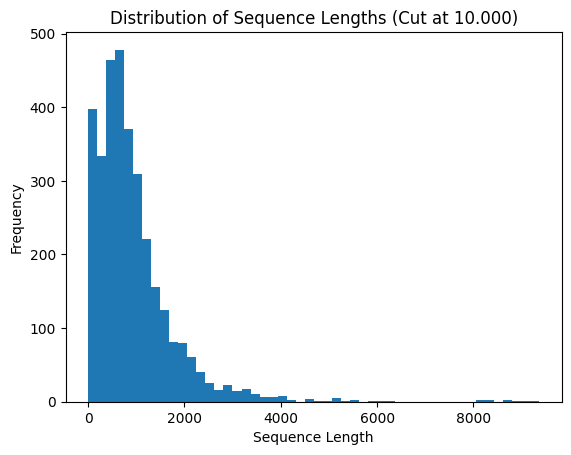

In [9]:
# Plot the sequence lengths
plt.hist(df_filtered['sequence_length'], bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths (Cut at 10.000)')
plt.show()

In [10]:
max_sequence_length = 4000
df_filtered = df[df['sequence_length'] <= max_sequence_length]

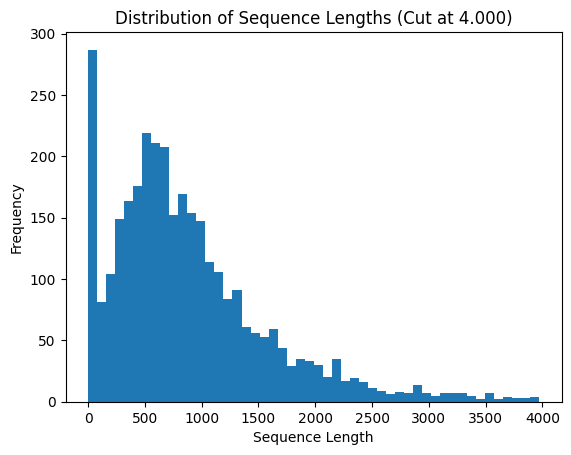

In [11]:
# Plot the sequence lengths
plt.hist(df_filtered['sequence_length'], bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths (Cut at 4.000)')
plt.show()

As one can see, we have a skewed distribution of the `sequence_length` in our data. Some sequences include 15.000, 23.000 or even almost 35.000 words.

Two strategies are possible:
*   Just truncate inputs for BERT (max. 512 words/tokens) --> information loss
*   Split sequences that are too long in several shorter sequences, so that we meet our length constraint



In [12]:
# Function to tokenize and encode the text using BERT tokenizer
def tokenize_and_encode(text):
    tokens = tokenizer.tokenize(text)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    token_ids = token_ids[:510] # Truncate to maximum sequence length of 510 tokens, reserve space for special tokens
    token_ids = [tokenizer.cls_token_id] + token_ids + [tokenizer.sep_token_id] # Add special tokens
    attention_mask = [1] * len(token_ids) # Create attention mask

    # Padding
    padding_length = 512 - len(token_ids)
    token_ids += [tokenizer.pad_token_id] * padding_length
    attention_mask += [0] * padding_length

    return token_ids, attention_mask

In [13]:
# Prepare input tensors for BERT
token_ids_list = []
attention_masks_list = []

for text in df['Content']:
    token_ids, attention_mask = tokenize_and_encode(text)
    token_ids_list.append(token_ids)
    attention_masks_list.append(attention_mask)

token_ids_tensor = torch.tensor(token_ids_list)
attention_masks_tensor = torch.tensor(attention_masks_list)

# Use BERT model to obtain word vectors
with torch.no_grad():
    model.eval()
    outputs = model(token_ids_tensor, attention_masks_tensor)
    embeddings = outputs[0] # Extract the word embeddings

: 

: 